# Comparisons In A Given Loss Landscape

In [1]:
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt

from minima_volume.analysis_funcs import (  grab_folder_names,
                                            load_base_train_size,
                                            list_additional_data,
                                            multiple_minima_fixed_landscape,
                                            fixed_landscape_minima_labels,
                                            plot_fixed_landscape_minima_pair,
                                            model_volume_across_targets,
                                            append_cutoff_points,
                                            varying_landscape_minima_labels,
                                            plot_minima_volume_vs_data_level,
)

loss_value = 0.1  # Loss value to analyze
data_level_log = False #Is the data log distributed?
base_output_dir = "analysis"  # Root folder to save all plots
os.makedirs(base_output_dir, exist_ok=True)

# Data for the loss landscape levels
experiment_folders, data_modifications = grab_folder_names()

base_train_size = load_base_train_size(experiment_folders[0])
model_data_sizes = list_additional_data(experiment_folders[0])

base_shift = 0
if data_modifications[0].startswith("data_"):
    base_shift = base_train_size  # Shift to reflect true dataset size

print("Experiment folders: ", experiment_folders)
print("Different data levels where loss landscapes were computed:", data_modifications)
print("The base train size is: ", base_train_size)
print("Data levels where models were trained: ", model_data_sizes)

First entry: Model_0, base_train_size = 60
Experiment folders:  ['model_0_data_10', 'model_1_data_11', 'model_2_data_12', 'model_3_data_13']
Different data levels where loss landscapes were computed: ['data_0', 'data_1940', 'data_19940', 'data_540', 'data_5940']
The base train size is:  60
Data levels where models were trained:  [0, 1940, 19940, 540, 5940, 59940]


## Plotting Different Model Volumes In A Landscape


Processing data modification folder: data_0


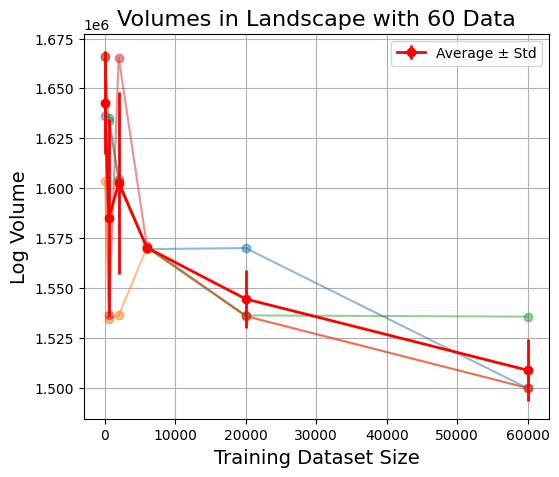

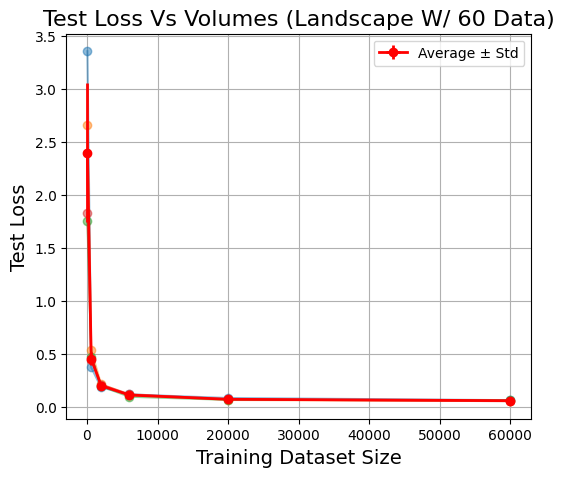

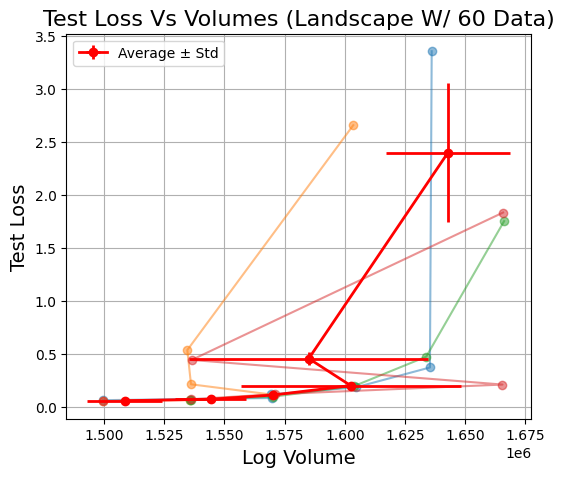


Processing data modification folder: data_1940


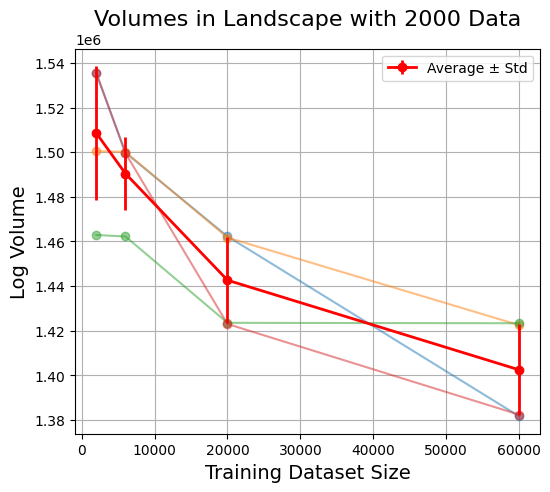

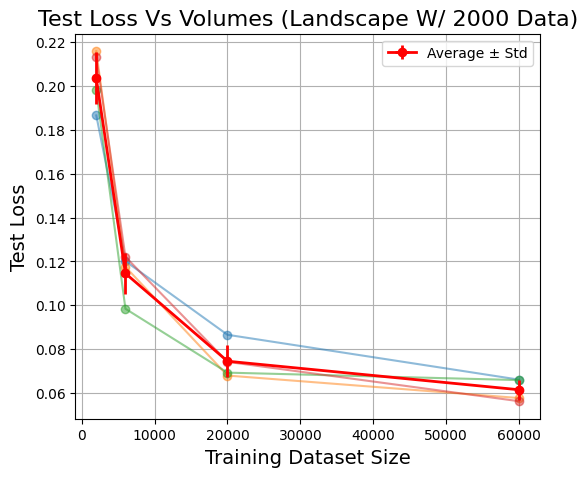

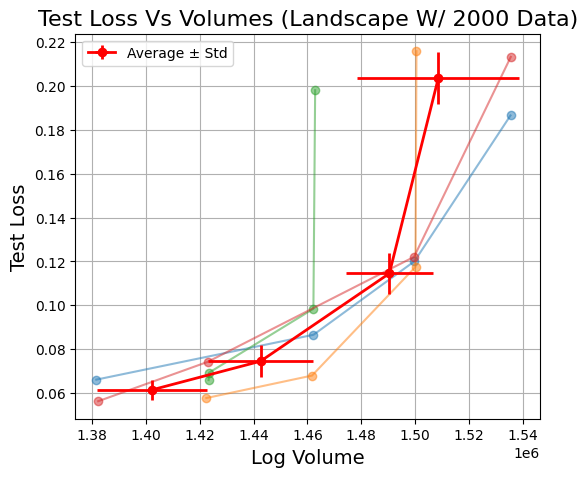


Processing data modification folder: data_19940


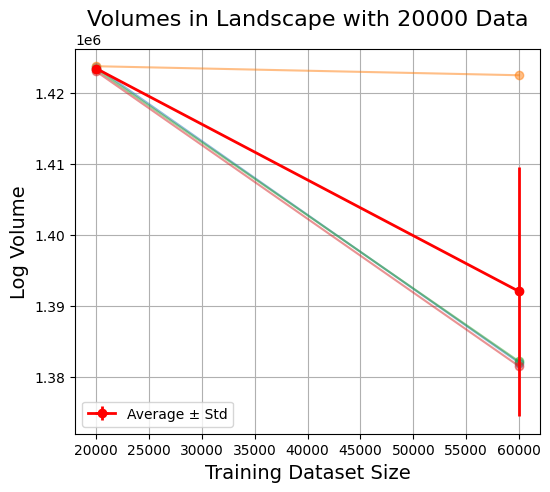

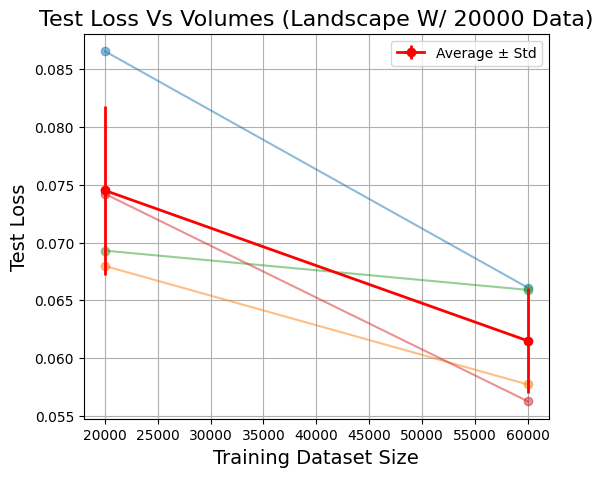

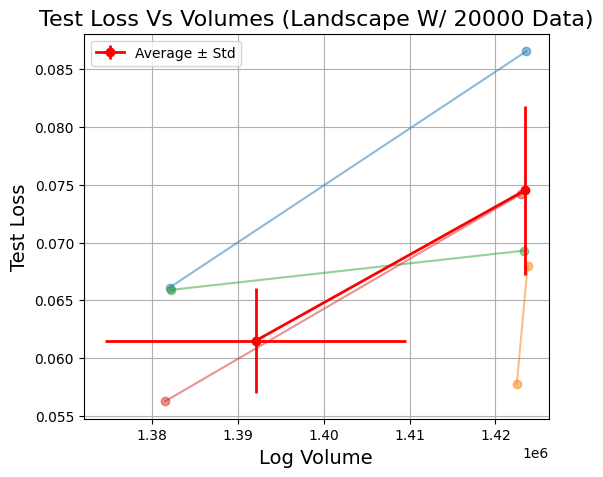


Processing data modification folder: data_540


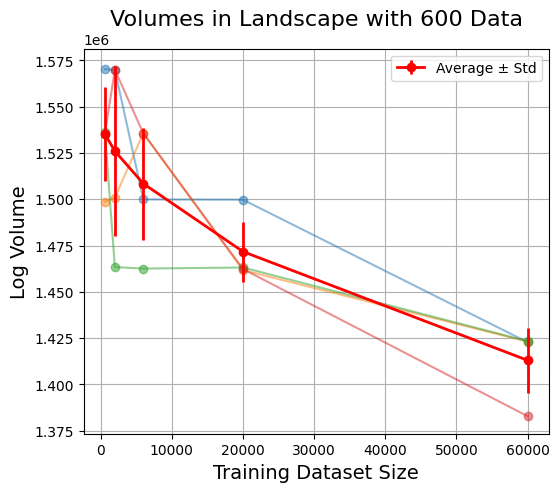

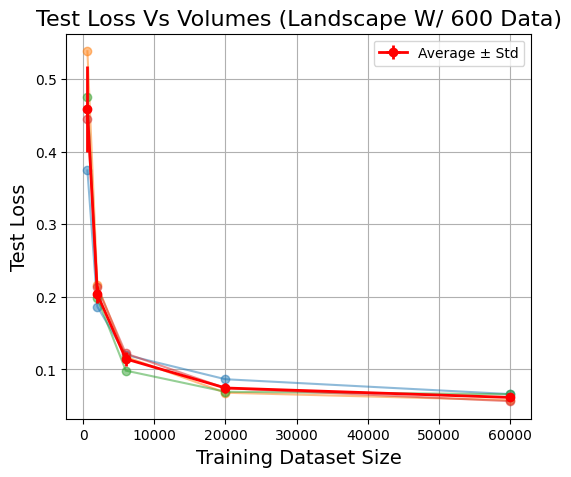

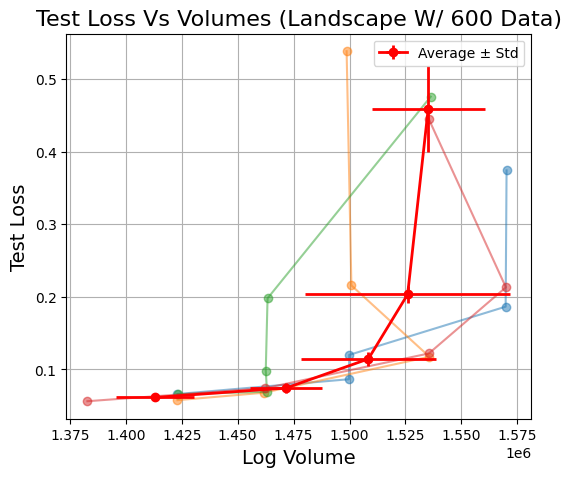


Processing data modification folder: data_5940


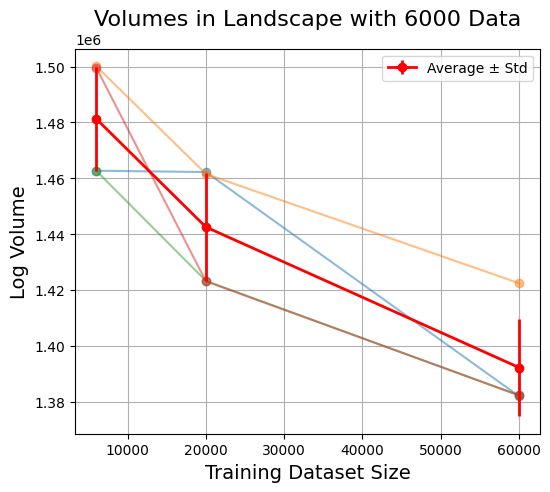

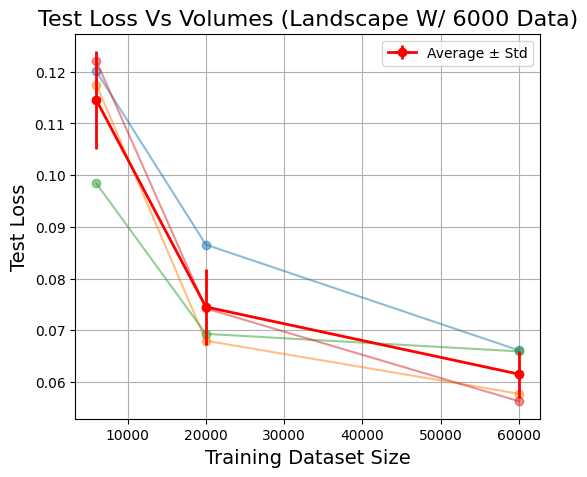

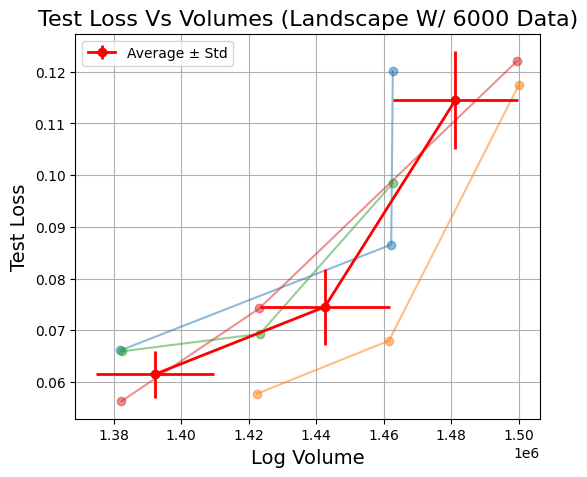

In [2]:
for data_modification in data_modifications:
    print(f"\nProcessing data modification folder: {data_modification}")

    # Create output folder for this data_modification
    save_dir = os.path.join(base_output_dir, data_modification)
    os.makedirs(save_dir, exist_ok=True)

    # Get axis labels and titles
    labels = fixed_landscape_minima_labels(data_modification, base_train_size)

    # Extract minima landscapes
    all_mdl, all_log_rn, all_test_loss = multiple_minima_fixed_landscape(
        experiment_folders, data_modification, loss_value
    )

    # Plot: Data level vs Log Volume
    plot_fixed_landscape_minima_pair(
        all_mdl, all_log_rn,
        xlabel=labels["xlabel"], ylabel="Log Volume",
        title=labels["title_volume"],
        log_scale=data_level_log,
        ranking=False,
        alpha=0.5,
        output_dir=save_dir, filename="data_level_vs_log_volume",
        plot_average=True,
        xlabel_size=14, ylabel_size=14, title_size=16,
        base_shift=base_shift,
    )

    # Plot: Data level vs Test Loss
    plot_fixed_landscape_minima_pair(
        all_mdl, all_test_loss,
        xlabel=labels["xlabel"], ylabel="Test Loss",
        title=labels["title_loss"],
        log_scale=False,
        ranking=False,
        alpha=0.5,
        output_dir=save_dir, filename="data_level_vs_test_loss",
        plot_average=True,
        xlabel_size=14, ylabel_size=14, title_size=16,
        base_shift=base_shift,
    )

    # Plot: Log Volume vs Test Loss
    plot_fixed_landscape_minima_pair(
        all_log_rn, all_test_loss,
        xlabel="Log Volume", ylabel="Test Loss",
        title=labels["title_loss"],
        log_scale=False,
        ranking=False,
        alpha=0.5,
        output_dir=save_dir, filename="log_volume_vs_test_loss",
        plot_average=True,
        xlabel_size=14, ylabel_size=14, title_size=16
    )

    ## Rank variant
    # Plot: Data level vs Log Volume
    plot_fixed_landscape_minima_pair(
        all_mdl, all_log_rn,
        xlabel=labels["xlabel"], ylabel="Log Volume",
        title=labels["title_volume"],
        log_scale=False,
        ranking=True,
        alpha=0.5,
        output_dir=os.path.join(save_dir, "ranks"), filename="data_level_vs_log_volume",
        show_plot = False,
        plot_average=True,
        xlabel_size=14, ylabel_size=14, title_size=16,
        base_shift=base_shift,
    )

    # Plot: Data level vs Test Loss
    plot_fixed_landscape_minima_pair(
        all_mdl, all_test_loss,
        xlabel=labels["xlabel"], ylabel="Test Loss",
        title=labels["title_loss"],
        log_scale=False,
        ranking=True,
        alpha=0.5,
        output_dir=os.path.join(save_dir, "ranks"), filename="data_level_vs_test_loss",
        show_plot = False,
        plot_average=True,
        xlabel_size=14, ylabel_size=14, title_size=16,
        base_shift=base_shift,
    )

    # Plot: Log Volume vs Test Loss
    plot_fixed_landscape_minima_pair(
        all_log_rn, all_test_loss,
        xlabel="Log Volume", ylabel="Test Loss",
        title=labels["title_loss"],
        log_scale=False,
        ranking=True,
        alpha=0.5,
        output_dir=os.path.join(save_dir, "ranks"), filename="log_volume_vs_test_loss",
        show_plot = False,
        plot_average=True,
        xlabel_size=14, ylabel_size=14, title_size=16
    )

# Comparisons Across Loss Landscapes



Here, we track the performance of all models across all loss landscapes.

Collected results for 4 experiments
Collected results for 4 experiments
Collected results for 4 experiments
Collected results for 4 experiments
Collected results for 4 experiments
Collected results for 4 experiments
Model_0: first exceedance at index 62 (value=0.3296201825141907, threshold=0.1)
Appended cutoff for model_0_data_10 | target=0, cutoff_idx=62
Model_0: first exceedance at index 62 (value=0.40641817450523376, threshold=0.1)
Appended cutoff for model_1_data_11 | target=0, cutoff_idx=62
Model_0: first exceedance at index 64 (value=0.18777482211589813, threshold=0.1)
Appended cutoff for model_2_data_12 | target=0, cutoff_idx=64
Model_0: first exceedance at index 65 (value=0.12450727075338364, threshold=0.1)
Appended cutoff for model_3_data_13 | target=0, cutoff_idx=65
Model_540: first exceedance at index 796 (value=0.10280945152044296, threshold=0.1)
Appended cutoff for model_0_data_10 | target=540, cutoff_idx=796
Model_540: first exceedance at index 746 (value=0.10568418353796

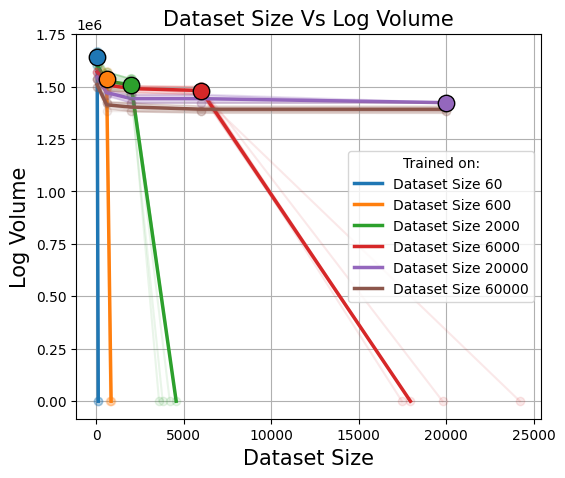

In [3]:
# For the poisoning experiments, this plot has no meaning

labels = varying_landscape_minima_labels(
    data_modification_folder=data_modifications[0], # Random choice to grab datatype from
    base_train_size=base_train_size,
)

results_dict = model_volume_across_targets(
    target_model_data_levels=model_data_sizes,
    loss_value=loss_value,
    experiment_folders=experiment_folders
)
results_with_cutoff = append_cutoff_points(results_dict, threshold=loss_value, base_dir=".")

plot_minima_volume_vs_data_level(
    results_dict = results_with_cutoff,
    data_type=labels["data_type"],          # NEW: needed for correct legend labels
    base_train_size=base_train_size,  # NEW: used for dataset size shifts
    xlabel=labels["xlabel"],
    ylabel="Log Volume",
    title=labels["title_volume"],
    log_scale = data_level_log,
    alpha=0.1,
    plot_average=True,
    output_dir=base_output_dir, filename="log_volumes_vs_data_levels",
    xlabel_size=15, ylabel_size=15, title_size=15
)

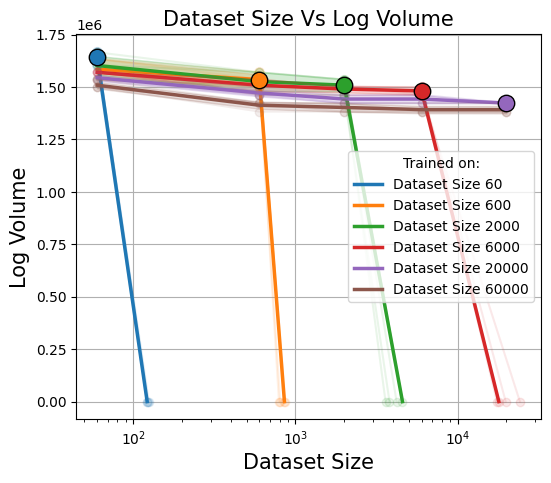

In [4]:
plot_minima_volume_vs_data_level(
    results_dict = results_with_cutoff,
    data_type=labels["data_type"],          # NEW: needed for correct legend labels
    base_train_size=base_train_size,  # NEW: used for dataset size shifts
    xlabel=labels["xlabel"],
    ylabel="Log Volume",
    title=labels["title_volume"],
    log_scale = True,
    alpha=0.1,
    plot_average=True,
    output_dir=base_output_dir, filename="log_volumes_vs_data_levels_log",
    xlabel_size=15, ylabel_size=15, title_size=15
)